In [8]:
import os
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor

from PIL import Image

#
torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16).to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.cuda.empty_cache()

@torch.no_grad()
def check_artist(artist):

    #
    prompt = ["Image in the style of ", "Painting in the style of ", "Art inspired by ", 
              "A reproduction of art by ", "A famous artwork by ", ""]
    prompt = [p + artist for p in prompt]
    prompt_count = len(prompt)
    seed = 10

    #
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(100)

    prompt = prompt + [""] * prompt_count

    token = pipeline.tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    embd = pipeline.text_encoder(token)[0]

    generator = torch.Generator(device=device).manual_seed(seed)
    latent = torch.randn((1, 4, 64, 64), generator=generator, device=device, dtype=torch.float16)
    latent = torch.cat([latent] * prompt_count) * scheduler.init_noise_sigma

    for t in scheduler.timesteps:

        latent_input = torch.cat([latent] * 2)
        latent_input = scheduler.scale_model_input(latent_input, timestep=t)

        noise = pipeline.unet(latent_input, t, encoder_hidden_states=embd).sample
        cond_noise, uncond_noise = noise.chunk(2)
        noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

        latent = scheduler.step(noise, t, latent).prev_sample

    latent /= 0.18215
    image = pipeline.vae.decode(latent).sample.detach().cpu().numpy()
    image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
    image = (image * 255).round().astype("uint8")
    # image = [Image.fromarray(i) for i in image]

    torch.cuda.empty_cache()

    input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=False)
    output = model(**input)
    image_embd = output.image_embeds
    text_embd = output.text_embeds

    score = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)

    return score

check_artist("Brent Cotton")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor

from PIL import Image

#
torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16).to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.cuda.empty_cache()


#
@torch.no_grad()
def generate_image(artist):

    # prompt = ["", "Image in the style of ", 
    #           "An image in the style of ",  "Create an image in the style of ",]
    # prompt = [p + artist for p in prompt]

    prompt = [artist] * 5

    prompt_count = len(prompt)
    seed = 3

    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(100)

    prompt = prompt + [""] * prompt_count

    token = pipeline.tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    embd = pipeline.text_encoder(token)[0]

    generator = torch.Generator(device=device).manual_seed(seed)
    # latent = torch.randn((1, 4, 64, 64), generator=generator, device=device, dtype=torch.float16)
    # latent = torch.cat([latent] * prompt_count) * scheduler.init_noise_sigma
    latent = torch.randn((prompt_count, 4, 64, 64), generator=generator, device=device, dtype=torch.float16) * scheduler.init_noise_sigma

    for t in scheduler.timesteps:

        latent_input = torch.cat([latent] * 2)
        latent_input = scheduler.scale_model_input(latent_input, timestep=t)

        noise = pipeline.unet(latent_input, t, encoder_hidden_states=embd).sample
        cond_noise, uncond_noise = noise.chunk(2)
        noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

        latent = scheduler.step(noise, t, latent).prev_sample

    latent /= 0.18215
    image = pipeline.vae.decode(latent).sample.detach().cpu().numpy()
    image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
    image = (image * 255).round().astype("uint8")
    image = [Image.fromarray(i) for i in image]

    torch.cuda.empty_cache()

    return image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import os
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor

from PIL import Image

#
torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16).to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.cuda.empty_cache()


#
@torch.no_grad()
def evaluate_image(artist):

    prompt = [artist] * 10

    prompt_count = len(prompt)
    seed = 3

    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(100)

    prompt = prompt + [""] * prompt_count

    token = pipeline.tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    embd = pipeline.text_encoder(token)[0]

    generator = torch.Generator(device=device).manual_seed(seed)
    # latent = torch.randn((1, 4, 64, 64), generator=generator, device=device, dtype=torch.float16)
    # latent = torch.cat([latent] * prompt_count) * scheduler.init_noise_sigma
    latent = torch.randn((prompt_count, 4, 64, 64), generator=generator, device=device, dtype=torch.float16) * scheduler.init_noise_sigma

    for t in scheduler.timesteps:

        latent_input = torch.cat([latent] * 2)
        latent_input = scheduler.scale_model_input(latent_input, timestep=t)

        noise = pipeline.unet(latent_input, t, encoder_hidden_states=embd).sample
        cond_noise, uncond_noise = noise.chunk(2)
        noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

        latent = scheduler.step(noise, t, latent).prev_sample

    latent /= 0.18215
    image = pipeline.vae.decode(latent).sample.detach().cpu().numpy()
    image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
    image = (image * 255).round().astype("uint8")
    image = [Image.fromarray(i) for i in image]

    torch.cuda.empty_cache()

    prompt = [artist] * 10

    input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True)
    output = model(**input)
    image_embd = output.image_embeds
    text_embd = output.text_embeds

    score = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)

    return image

In [ ]:
f"An image in the style of {artist}"

In [ ]:
for artist in artist_list:
    if "ica" in artist:
        print(artist)

Jessica Woulfe
Judy Chicago
Théodore Géricault
Jessica Rossier
Pablo Picasso
Helio Oiticica
Francis Picabia


In [15]:
artist_list = list(pd.read_csv("prompt/artists1734_prompts.csv")["artist"])
artist_list[-1]

'Étienne-Louis Boullée'

In [ ]:
artist_list = list(pd.read_csv("../prompt/artist1734_1.csv")["artist"])

In [ ]:
#
score_dict = {}
artist_list = list(pd.read_csv("../prompt/artist1734_1.csv")["artist"])
for i in range(10):
    artist = random.choice(artist_list)
    prompt = [artist] * 6
    image = generate_image(artist)

    input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True)
    output = model(**input)
    image_embd = output.image_embeds
    text_embd = output.text_embeds

    score = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)
    score_dict[artist] = list(score)

In [ ]:
import os
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor

from PIL import Image


#
torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16).to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Helio Oiticica


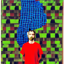

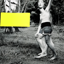

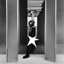

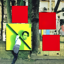

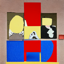

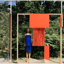

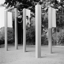

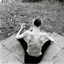

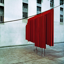

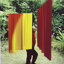

,Helio Oiticica,An image in the style of Helio Oiticica,A painting of an artist,
0,0.288,0.285,0.263,0.220
1,0.267,0.271,0.212,0.201
2,0.278,0.260,0.213,0.201
3,0.305,0.292,0.237,0.217
4,0.284,0.282,0.274,0.225
5,0.311,0.280,0.245,0.207
6,0.290,0.251,0.197,0.222
7,0.283,0.249,0.215,0.223
8,0.308,0.277,0.223,0.212
9,0.314,0.284,0.257,0.235


In [ ]:
#
artist = "Helio Oiticica"
prompt = [f"An image in the style of {artist}"] * 5 + [f"{artist}"] * 5

prompt_count = len(prompt)
seed = 5

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(100)

prompt = prompt + [""] * prompt_count

token = pipeline.tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
embd = pipeline.text_encoder(token)[0]

generator = torch.Generator(device=device).manual_seed(seed)
# latent = torch.randn((1, 4, 64, 64), generator=generator, device=device, dtype=torch.float16)
# latent = torch.cat([latent] * prompt_count) * scheduler.init_noise_sigma
latent = torch.randn((prompt_count, 4, 64, 64), generator=generator, device=device, dtype=torch.float16) * scheduler.init_noise_sigma

for t in scheduler.timesteps:

    latent_input = torch.cat([latent] * 2)
    latent_input = scheduler.scale_model_input(latent_input, timestep=t)

    noise = pipeline.unet(latent_input, t, encoder_hidden_states=embd).sample
    cond_noise, uncond_noise = noise.chunk(2)
    noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

    latent = scheduler.step(noise, t, latent).prev_sample

latent /= 0.18215
image = pipeline.vae.decode(latent).sample.detach().cpu().numpy()
image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
image = (image * 255).round().astype("uint8")
image = [Image.fromarray(i) for i in image]

torch.cuda.empty_cache()

print(artist)
for i in image:    
    display(i.resize((64, 64)))


#
prompt = [f"{artist}"] * prompt_count
input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True)
output = model(**input)
image_embd = output.image_embeds
text_embd = output.text_embeds
score1 = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)

prompt = [f"An image in the style of {artist}"] * prompt_count
input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True)
output = model(**input)
image_embd = output.image_embeds
text_embd = output.text_embeds
score2 = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)

prompt = ["A painting of an artist"] * prompt_count
input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True)
output = model(**input)
image_embd = output.image_embeds
text_embd = output.text_embeds
score3 = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)

prompt = [""] * prompt_count
input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True)
output = model(**input)
image_embd = output.image_embeds
text_embd = output.text_embeds
score4 = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)


display(pd.DataFrame({f"{artist}":score1, f"An image in the style of {artist}":score2,
                      "A painting of an artist":score3, "":score4}))

In [ ]:
import os
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor

from PIL import Image


#
torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16).to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.cuda.empty_cache()

#
artist = list(pd.read_csv("prompt/artist1734_1.csv")["artist"])[1500:1800]

valid_artist = []
for a in artist:
    prompt = [f"An image in the style of {a}"]

    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(100)

    cfg_prompt = prompt + [""]
    token = pipeline.tokenizer(cfg_prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    embd = pipeline.text_encoder(token)[0]

    latent = torch.randn((1, 4, 64, 64), device=device, dtype=torch.float16) * scheduler.init_noise_sigma

    for t in scheduler.timesteps:
        latent_input = torch.cat([latent] * 2)
        latent_input = scheduler.scale_model_input(latent_input, timestep=t)

        noise = pipeline.unet(latent_input, t, encoder_hidden_states=embd).sample
        cond_noise, uncond_noise = noise.chunk(2)
        noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

        latent = scheduler.step(noise, t, latent).prev_sample

    latent /= 0.18215
    image = pipeline.vae.decode(latent).sample.detach().cpu().numpy()
    image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
    image = (image * 255).round().astype("uint8")
    image = [Image.fromarray(i) for i in image]

    torch.cuda.empty_cache()

    input = processor(text=prompt, images=image, return_tensors="pt", padding=True, do_rescale=True).to(device)
    output = model(**input)
    image_embd = output.image_embeds
    text_embd = output.text_embeds
    score = torch.nn.functional.cosine_similarity(image_embd, text_embd).detach().cpu().numpy().item()
    print(score)

    if score > 0.29:
        valid_artist.append(a)

#
data = {"valid_artist": valid_artist}

with open(f"valid_artist1.yaml", 'w') as file:
    yaml.dump(data, file)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

0.3004106283187866
0.3158748745918274
0.314837783575058
0.20080965757369995
0.2078261375427246
0.3352721333503723
0.2922140955924988
0.27980607748031616
0.31561562418937683
0.25140878558158875
0.15310893952846527
0.3055914044380188
0.3259897828102112
0.2613677680492401
0.33682137727737427
0.2734815776348114
0.29797929525375366
0.2919931411743164
0.25649744272232056
0.2985376715660095
0.3268444836139679
0.24742160737514496
0.2514830231666565
0.301169753074646
0.30762457847595215
0.32151028513908386
0.31189262866973877
0.30610141158103943
0.29867684841156006
0.31643572449684143
0.28920090198516846
0.2592966854572296
0.31097036600112915
0.24617907404899597
0.2986026406288147
0.3284849524497986
0.2813248038291931
0.27528178691864014
0.31641170382499695
0.32449156045913696
0.2953495681285858
0.2982924282550812
0.3173527419567108
0.3015371561050415
0.2830807566642761
0.30476367473602295
0.3215388059616089
0.26752984523773193
0.31095272302627563
0.286867618560791
0.31432652473449707
0.2770442

In [4]:
with open(f"valid_artist1.yaml", 'w') as file:
    yaml.dump(data, file)

In [2]:
import yaml

data = []
for i in [300, 600, 900, 1200, 1500, 1800]:

    with open(f"{i}.yaml", 'r', encoding='utf-8') as file:
        data += yaml.safe_load(file)["artist_list2"]

In [3]:
data

['Mike Worrall',
 'Carne Griffiths',
 'Chuck Close',
 'Slim Aarons',
 'Hans Baldung',
 'Hiroshi Yoshida',
 'Diego Rivera',
 'Dunkelbunt Hundertwasser',
 'Guerrilla Girls',
 'Harry Clarke',
 'Charles Addams',
 'Glenn Fabry',
 'Irma Stern',
 'Tomasz Alen Kopera',
 'Marco Mazzoni',
 'Andreas Vesalius',
 'Juan Gris',
 'Mark Keathley',
 'Jamie Hewlett',
 'Nick Knight',
 'Ernst Haas',
 'Frank Lloyd Wright',
 'Claude Monet',
 'Alice Bailly',
 'Mary Cassatt',
 'Ron Mueck',
 'Evelyn De Morgan',
 'Auguste Herbin',
 'Edgar Degas',
 'Ilya Repin',
 'Michal Karcz',
 'Kay Sage',
 'Akira Toriyama',
 'John French Sloan',
 'Aaron Jasinski',
 'Bernardo Bellotto',
 'Alfred Cheney Johnston',
 'Kathryn Morris Trotter',
 'Jeff Lemire',
 'Julie Blackmon',
 'Filippino Lippi',
 'Edouard Manet',
 'Patrick Dougherty',
 'Adriaen van Ostade',
 'Marina Abramović',
 'Agostino Tassi',
 'Rob Liefeld',
 'Alfred Munnings',
 'John La Farge',
 'Sandy Skoglund',
 'M.W. Kaluta',
 'Robert Hagan',
 'J. J. Grandville',
 'Larry 

In [ ]:
import pandas as pd

import yaml

with open(f"600.yaml", 'r', encoding='utf-8') as file:
    data600 = yaml.safe_load(file)

with open(f"300.yaml", 'r', encoding='utf-8') as file:
    data300 = yaml.safe_load(file)

df = pd.read_csv("prompt/artist1734_1.csv")["artist"]

prompts = set(df)
new_artist_set = set(data300["artist_list2"] + data600["artist_list2"])
old_artist_list = list(prompts - new_artist_set)
new_artist_list = list(new_artist_set)



In [ ]:
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd

import torch
from diffusers import UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer


prev_prompts = new_artist_list[:5] + old_artist_list[:5]
new_prompts = ["art"] * 10
retain_prompts = new_artist_list[5:] + old_artist_list[5:]

prompts = prev_prompts + retain_prompts
seeds = [random.randint(1000, 5000) for _ in prompts]

@torch.no_grad()
def erase_unet(version, model_name, prev_prompts, new_prompts, retain_prompts,
               lamb, erase_scale, preserve_scale, with_key):

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    unet = UNet2DConditionModel.from_pretrained(version, subfolder="unet").to(device)
    tokenizer = CLIPTokenizer.from_pretrained(version, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(version, subfolder="text_encoder").to(device)

    ca_layers = []
    for name, module in unet.named_modules():
        if name[-5:] != "attn2": continue
        ca_layers.append(module)

    value_layers = [layer.to_v for layer in ca_layers]
    target_layers = value_layers

    if with_key:
        key_layers = [layer.to_k for layer in ca_layers]
        target_layers += key_layers
    
    prev_tokens = tokenizer(prev_prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    prev_embds = text_encoder(prev_tokens)[0].permute(0, 2, 1)
    
    new_tokens = tokenizer(new_prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    new_embds = text_encoder(new_tokens)[0].permute(0, 2, 1)

    m2 = (prev_embds @ prev_embds.permute(0, 2, 1)).sum(0) * erase_scale
    m2 += lamb * torch.eye(m2.shape[0], device=device)

    m3 = (new_embds @ prev_embds.permute(0, 2, 1)).sum(0) * erase_scale
    m3 += lamb * torch.eye(m3.shape[0], device=device)

    if retain_prompts:

        retain_tokens = tokenizer(retain_prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
        retain_embds = text_encoder(retain_tokens)[0].permute(0, 2, 1)

        m2 += (retain_embds @ retain_embds.permute(0, 2, 1)).sum(0) * preserve_scale
        m3 += (retain_embds @ retain_embds.permute(0, 2, 1)).sum(0) * preserve_scale

    for target_layer in target_layers:
        m1 = target_layer.weight @ m3
        target_layer.weight = torch.nn.Parameter((m1 @ torch.inverse(m2)).detach())

    torch.save(unet.state_dict(), f"model/{model_name}.pth")

version = "stabilityai/stable-diffusion-2-1-base"
model_name = "artist5new5erase_1"
lamb = 0.5
erase_scale = 1
preserve_scale = 0.1
with_key = True

erase_unet(version, model_name, prev_prompts, new_prompts, retain_prompts,
           lamb, erase_scale, preserve_scale, with_key)

data = {"prompts": prompts,
        "prev_prompts": prev_prompts,
        "new_prompts": new_prompts,
        "retain_prompts": retain_prompts,
        "seeds": seeds,
        "version": version,
        "model_name": model_name,
        "lamb": lamb,
        "erase_scale": erase_scale,
        "preserve_scale": preserve_scale, 
        "with_key": with_key,}

with open(f"data/{model_name}.yaml", 'w') as file:
    yaml.dump(data, file)

In [ ]:
import random
import warnings

warnings.filterwarnings("ignore")

import yaml

import pandas as pd

import torch
from diffusers import UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer


prev_prompts = new_artist_list[:10]
new_prompts = ["art"] * 10
retain_prompts = new_artist_list[10:]

prompts = prev_prompts + retain_prompts
seeds = [random.randint(1000, 5000) for _ in prompts]

@torch.no_grad()
def erase_unet(version, model_name, prev_prompts, new_prompts, retain_prompts,
               lamb, erase_scale, preserve_scale, with_key):

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    unet = UNet2DConditionModel.from_pretrained(version, subfolder="unet").to(device)
    tokenizer = CLIPTokenizer.from_pretrained(version, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(version, subfolder="text_encoder").to(device)

    ca_layers = []
    for name, module in unet.named_modules():
        if name[-5:] != "attn2": continue
        ca_layers.append(module)

    value_layers = [layer.to_v for layer in ca_layers]
    target_layers = value_layers

    if with_key:
        key_layers = [layer.to_k for layer in ca_layers]
        target_layers += key_layers
    
    prev_tokens = tokenizer(prev_prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    prev_embds = text_encoder(prev_tokens)[0].permute(0, 2, 1)
    
    new_tokens = tokenizer(new_prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
    new_embds = text_encoder(new_tokens)[0].permute(0, 2, 1)

    m2 = (prev_embds @ prev_embds.permute(0, 2, 1)).sum(0) * erase_scale
    m2 += lamb * torch.eye(m2.shape[0], device=device)

    m3 = (new_embds @ prev_embds.permute(0, 2, 1)).sum(0) * erase_scale
    m3 += lamb * torch.eye(m3.shape[0], device=device)

    if retain_prompts:

        retain_tokens = tokenizer(retain_prompts, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
        retain_embds = text_encoder(retain_tokens)[0].permute(0, 2, 1)

        m2 += (retain_embds @ retain_embds.permute(0, 2, 1)).sum(0) * preserve_scale
        m3 += (retain_embds @ retain_embds.permute(0, 2, 1)).sum(0) * preserve_scale

    for target_layer in target_layers:
        m1 = target_layer.weight @ m3
        target_layer.weight = torch.nn.Parameter((m1 @ torch.inverse(m2)).detach())

    torch.save(unet.state_dict(), f"model/{model_name}.pth")

version = "stabilityai/stable-diffusion-2-1-base"
model_name = "new10erase_1"
lamb = 0.5
erase_scale = 1
preserve_scale = 0.1
with_key = True

erase_unet(version, model_name, prev_prompts, new_prompts, retain_prompts,
           lamb, erase_scale, preserve_scale, with_key)

data = {"prompts": prompts,
        "prev_prompts": prev_prompts,
        "new_prompts": new_prompts,
        "retain_prompts": retain_prompts,
        "seeds": seeds,
        "version": version,
        "model_name": model_name,
        "lamb": lamb,
        "erase_scale": erase_scale,
        "preserve_scale": preserve_scale, 
        "with_key": with_key,}

with open(f"data/{model_name}.yaml", 'w') as file:
    yaml.dump(data, file)

In [9]:
import os
import warnings

warnings.filterwarnings("ignore")

import yaml

from tqdm.auto import tqdm

import torch
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor, CLIPTextModel, CLIPTokenizer

from PIL import Image

version = "stabilityai/stable-diffusion-2-1-base"
model_name = "new10erase_1"

torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
unet = UNet2DConditionModel.from_pretrained(version, torch_dtype=torch.float16, subfolder="unet").to(device)
unet.load_state_dict(torch.load(f"model/{model_name}.pth"))
tokenizer = CLIPTokenizer.from_pretrained(version, torch_dtype=torch.float16, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(version, torch_dtype=torch.float16, subfolder="text_encoder").to(device)
vae = AutoencoderKL.from_pretrained(version, torch_dtype=torch.float16, subfolder="vae").to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.cuda.empty_cache()


with open(f"data/{model_name}.yaml", 'r', encoding='utf-8') as file:
    data = yaml.safe_load(file)

idx = 11

artist = data["prompts"][idx]
seed = data["seeds"]

prompt = [f"An image in the style of {artist}"] * 10
prompt_count = len(prompt)

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(100)

prompt = prompt + [""] * prompt_count

token = tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
embd = text_encoder(token)[0]

generator = torch.Generator(device=device).manual_seed(int(seed[idx]))
latent = torch.randn((prompt_count, 4, 64, 64), generator=generator, device=device, dtype=torch.float16)
latent *= scheduler.init_noise_sigma

for t in scheduler.timesteps:

    latent_input = torch.cat([latent] * 2)
    latent_input = scheduler.scale_model_input(latent_input, timestep=t)

    noise = unet(latent_input, t, encoder_hidden_states=embd).sample
    cond_noise, uncond_noise = noise.chunk(2)
    noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

    latent = scheduler.step(noise, t, latent).prev_sample

latent /= 0.18215
image = vae.decode(latent).sample.detach().cpu().numpy()
image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
image = (image * 255).round().astype("uint8")
image = [Image.fromarray(i) for i in image]


input = processor(text=prompt[:10], images=image, return_tensors="pt", padding=True, do_rescale=True)
output = model(**input)
image_embd = output.image_embeds
text_embd = output.text_embeds
score = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)
print(score.mean())

[0.272 0.311 0.305 0.324 0.312 0.296 0.301 0.29  0.26  0.296]


In [8]:
score.mean()

0.21970001

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

import yaml

from tqdm.auto import tqdm

import torch
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler
from transformers import CLIPModel, CLIPProcessor, CLIPTextModel, CLIPTokenizer

from PIL import Image

version = "stabilityai/stable-diffusion-2-1-base"
model_name = "new10erase_1"

torch.set_grad_enabled(False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
unet = UNet2DConditionModel.from_pretrained(version, torch_dtype=torch.float16, subfolder="unet").to(device)
unet.load_state_dict(torch.load(f"model/{model_name}.pth"))
tokenizer = CLIPTokenizer.from_pretrained(version, torch_dtype=torch.float16, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(version, torch_dtype=torch.float16, subfolder="text_encoder").to(device)
vae = AutoencoderKL.from_pretrained(version, torch_dtype=torch.float16, subfolder="vae").to(device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.cuda.empty_cache()


with open(f"data/{model_name}.yaml", 'r', encoding='utf-8') as file:
    data = yaml.safe_load(file)

idx = 11

artist = data["prompts"][idx]
seed = data["seeds"]

prompt = [f"An image in the style of {artist}"] * 10
prompt_count = len(prompt)

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(100)

prompt = prompt + [""] * prompt_count

token = tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids.to(device)
embd = text_encoder(token)[0]

generator = torch.Generator(device=device).manual_seed(int(seed[idx]))
latent = torch.randn((prompt_count, 4, 64, 64), generator=generator, device=device, dtype=torch.float16)
latent *= scheduler.init_noise_sigma

for t in scheduler.timesteps:

    latent_input = torch.cat([latent] * 2)
    latent_input = scheduler.scale_model_input(latent_input, timestep=t)

    noise = unet(latent_input, t, encoder_hidden_states=embd).sample
    cond_noise, uncond_noise = noise.chunk(2)
    noise = uncond_noise + 7.5 * (cond_noise - uncond_noise)

    latent = scheduler.step(noise, t, latent).prev_sample

latent /= 0.18215
image = vae.decode(latent).sample.detach().cpu().numpy()
image = ((image + 1) / 2).clip(0, 1).transpose(0, 2, 3, 1)
image = (image * 255).round().astype("uint8")
image = [Image.fromarray(i) for i in image]


input = processor(text=prompt[:10], images=image, return_tensors="pt", padding=True, do_rescale=True)
output = model(**input)
image_embd = output.image_embeds
text_embd = output.text_embeds
score = torch.nn.functional.cosine_similarity(image_embd, text_embd).numpy().round(3)
print(score.mean())